#### **PROGRAMA QUE UTILIZA MACHING LEARNIN PARA CLASIFICAR LOS MANGOS MADUROS Y PODRIDOS**
---


Este programa ilustra el uso de las librerías skimage, pathlib, numpy y matplotlib, para cargar un dataset de imagenes, inspeccionar datos, graficar y corregir errores. El conjunto de datos tomado para este trabajo es de: https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango

Este conjunto de datos cuenta con una clasificacion de 3 estados del mango, maduro(ripe), inmaduro(unripe) y podrido(rotten) con sus respectivas imagenes para el entrenamiento del modelo, de este conjunto de datos solo se tendran en cuenta los estados maduros y podridos, se trabajara con las mascaras de los mangos, el proceso para obtener estas mascaras no se tendra en cuneta en este trabajo.

El objetivo de estos conjuntos de imagenes es ser capas de difinir si un mango esta maduro(ripe) o podrido(rotten), usando ese conjunto de imagenes para entrenar este modelo.

In [1]:

import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
import os

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import pandas as pd
import numpy as np
import skimage as ski
import statistics

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects




Se creara la función obtener_imagenes(), la cual retornara una lista con donde cada celda contendra un vector con el nombre de la imagen, la imagen a color, la imagen en escala de grises y dejara una posicion disponible para la mascara de cada imagen, dichas mascaras estan en otra carpeta y se agregaran por medio de otra funcion.

In [2]:
def obtener_imagenes(ruta_carpeta):
    """Devuelve una lista de imágenes normales y en escala de grises de la carpeta especificada con el respectivo nombre de la imgen."""
    imagenes = []
    cont = 0
    for archivo in os.listdir(ruta_carpeta):
        try:
            img = ski.io.imread(ruta_carpeta+"/"+archivo)
            img = ski.util.img_as_ubyte(img)
            gray_image = rgb2gray(img)
            imagenes.append([archivo,img,gray_image, ""])
        except Exception as e:
            cont = cont + 1

    return imagenes

La funcion obtener_mask(), recibe como parametro la ruta en la que se encuentran las mascaras y la lista que contiene las imagenes con sus nombres, imagen, imagen en escala de grises y el espacion donde se almacenara la mascara correspondiente, cabe aclarar que las mascaras tienen el mismo nombre que la imagen original agregando mark_ripe o mark_rotten, estos separado por un guion bajo, al final retornara la lista que recibe con el espacio de la mascara lleno con su mascara correspondiente.

In [3]:
def obtener_mask(ruta_carpeta, coleccion):
    """Devuelve una lista de imágenes normales y en escala de grises de la carpeta especificada con el respectivo nombre de la imgen."""
    imagenes = []
    cont = 0
    carpeta = os.listdir(ruta_carpeta)
    for i in coleccion:
        nombre_img = obtener_primera_palabra(i[0],".")
        #print(nombre_img)
        for archivo in carpeta:

            nombre_mask = obtener_primera_palabra(archivo,"_")
            #print(nombre_mask, "y",nombre_img)
            if nombre_img == nombre_mask:
                mask = np.load(ruta_carpeta+"/"+archivo)
                if len(mask.shape) == 3:
                    mask=mask[:,:,1]
                i[3] = mask
                imagenes.append(i)
                break


    return imagenes

La funcion obtener_primera_palabra(),  permite obtener la palabra de una cadena que aparece antes del caracter que recibe por parametro.

In [4]:
def obtener_primera_palabra(palabra, caracter):
    p = palabra.split(caracter)
    return p[0]

La funcion intensity_table(), crea una tabla con el valor de la intensidad de la imagen en escala de grises

In [5]:
def intensity_table(grayValues):
    table = {}
    for ival in range(256):
        table['val_'+ str(ival)] = [np.count_nonzero(grayValues == ival)]

    df_table = pd.DataFrame.from_dict(table, orient='columns')
    return df_table

In [6]:
def hist2features(grayImg, mangoMask):
    #color = ski.util.img_as_ubyte(colorImg)
    gray = ski.util.img_as_ubyte(grayImg)
    #mango_mask = ski.util.invert(mangoMask)
    mango_mask = mangoMask

    masked_gray = gray * mango_mask
    plt.imshow(masked_gray, cmap = 'gray')
    plt.show()
    df_intensities = intensity_table(masked_gray)
    print(df_intensities)
    return df_intensities

In [8]:
ripe = obtener_imagenes("./ripe")
rotten = obtener_imagenes("./rotten")


In [9]:
ripe = obtener_mask("./ripe_masks",ripe)
rotten = obtener_mask("./rotten_masks",rotten)

Se busca ver graficamente la cantidad de imagenes que se tienen de los mangos ripe y los mangos rotten.

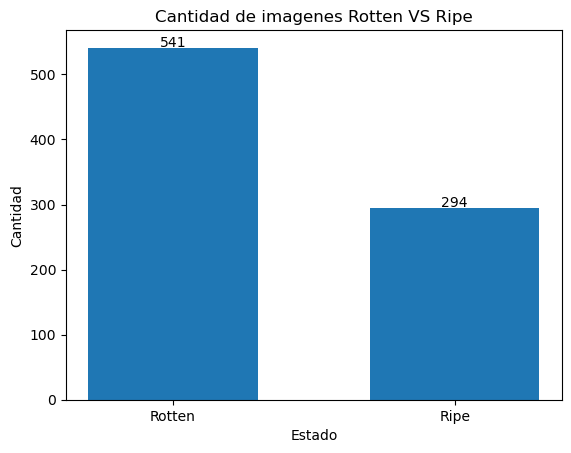

In [11]:
cantidad_imagenes_rotten= len(rotten)
cantidad_imagenes_ripe = len(ripe)

plt.bar(["Rotten", "Ripe"], [cantidad_imagenes_rotten, cantidad_imagenes_ripe], width=0.6)

#mostrar los valores sobre
plt.text(0,cantidad_imagenes_rotten +2, str(cantidad_imagenes_rotten), ha='center')
plt.text(1,cantidad_imagenes_ripe +2, str(cantidad_imagenes_ripe), ha='center')

# Personalizar el gráfico
plt.title('Cantidad de imagenes Rotten VS Ripe')
plt.ylabel('Cantidad')
plt.xlabel('Estado')

# Mostrar el gráfico
plt.show()


# Mostrar el gráfico
plt.show()

Como se ve en la grafica anterior, la cantidad de imagenes, se encuentra desbalanceada a favor de los mangos rotten, teniendo este casi el doble de imagenes de los mangos ripe.

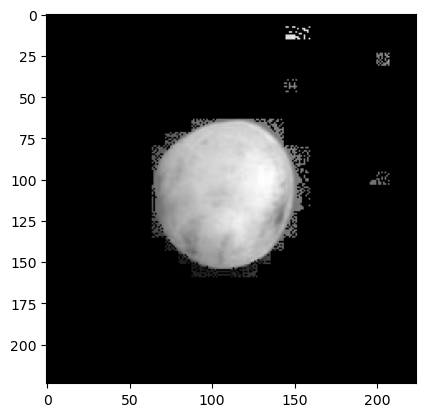

   val_0  val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  ...  \
0  43011      0      0      0      0      0      0      0      0      0  ...   

   val_246  val_247  val_248  val_249  val_250  val_251  val_252  val_253  \
0        0        0        0        0        0        0        0        0   

   val_254  val_255  
0        0        0  

[1 rows x 256 columns]


,val_0,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_246,val_247,val_248,val_249,val_250,val_251,val_252,val_253,val_254,val_255
0,43011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
a =112
imagen2 = ripe[a]
hist2features(imagen2[2],imagen2[3])

In [16]:
def extract_properties(mango_img, gray_img, mango_mask):

    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    object_features = ski.measure.regionprops(labeled_mango)

    var_color_props = ['intensity_mean']
    color_props = ski.measure.regionprops_table(labeled_mango, mango_img, properties=var_color_props)

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
    
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    
    df_image['mean_value_R'] = color_props['intensity_mean-0'] 
    df_image['mean_value_G'] = color_props['intensity_mean-1'] 
    df_image['mean_value_B'] = color_props['intensity_mean-2']
    df_image['std'] = grayImg_stdev 
    
    print(df_image.head())

In [17]:
def std_image(gray_img, mango_mask):
    mango_mask = ski.util.invert(mango_mask)
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev

In [18]:
extract_properties(imagen2[1],imagen2[2],imagen2[3])

     area  max_gray_value  min_gray_value  mean_gray_value  mean_value_R  \
0  4082.0        0.675431        0.072455         0.408536    138.810632   
1     5.0        0.153276        0.140082         0.148726     36.400000   
2     1.0        0.203224        0.203224         0.203224     36.000000   
3     2.0        0.209868        0.194182         0.202025     45.000000   
4     1.0        0.189910        0.189910         0.189910     48.000000   

   mean_value_G  mean_value_B       std  
0     99.591867     47.592357  0.059956  
1     37.000000     51.600000  0.059956  
2     56.000000     57.000000  0.059956  
3     53.000000     56.000000  0.059956  
4     49.000000     44.000000  0.059956  
